In [1]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Load the data
customers_df = pd.read_csv("Customers.csv")
transactions_df = pd.read_csv("Transactions.csv")

In [4]:

# 1. Data Preprocessing
df = transactions_df.merge(customers_df, on='CustomerID')


In [5]:
# Feature Engineering
# Calculate RFM (Recency, Frequency, Monetary) values
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])
max_date = df['TransactionDate'].max()

In [6]:
rfm = df.groupby('CustomerID').agg({
    'TransactionDate': lambda x: (max_date - x.max()).days,
    'TransactionID': 'count',
    'TotalValue': 'sum'
})

In [7]:
rfm.columns = ['Recency', 'Frequency', 'Monetary']

In [8]:
# Handle potential negative values (if any)
rfm['Recency'] = rfm['Recency'].apply(lambda x: 0 if x < 0 else x)

# Encode categorical variables
le = LabelEncoder()
customers_df['Region_Encoded'] = le.fit_transform(customers_df['Region'])

# Join RFM with customer profile information
customer_data = rfm.join(customers_df[['CustomerID', 'Region_Encoded']])


In [11]:
# 2. Impute Missing Values (using SimpleImputer)
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')
imputed_data = imputer.fit_transform(customer_data)


/usr/local/lib/python3.10/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['CustomerID' 'Region_Encoded']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


In [15]:
# 2. Feature Scaling
scaler = StandardScaler()
scaled_data = scaler.fit_transform(imputed_data)

In [16]:
# 3. Determine Optimal Number of Clusters (Elbow Method)
inertia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

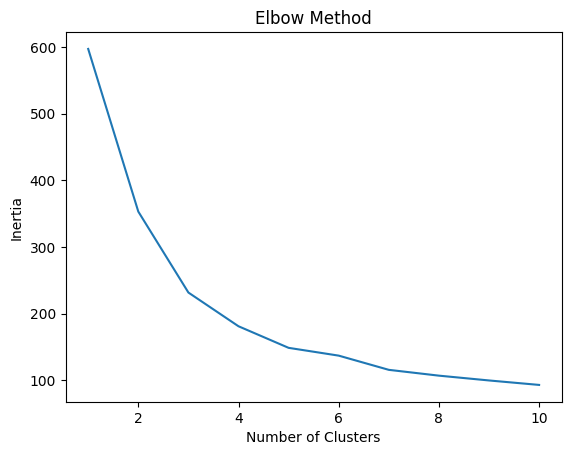

In [17]:
plt.plot(range(1, 11), inertia)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()


In [18]:
# 4. Perform K-Means Clustering
optimal_clusters = 4  # Based on the elbow plot, choose the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
customer_data['Cluster'] = kmeans.fit_predict(scaled_data)


In [19]:
# 5. Calculate Clustering Metrics
db_index = davies_bouldin_score(scaled_data, customer_data['Cluster'])
print(f"Davies-Bouldin Index: {db_index}")

Davies-Bouldin Index: 1.013212626152623


In [20]:
# 6. Visualize Clusters (using PCA for dimensionality reduction)
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_data)


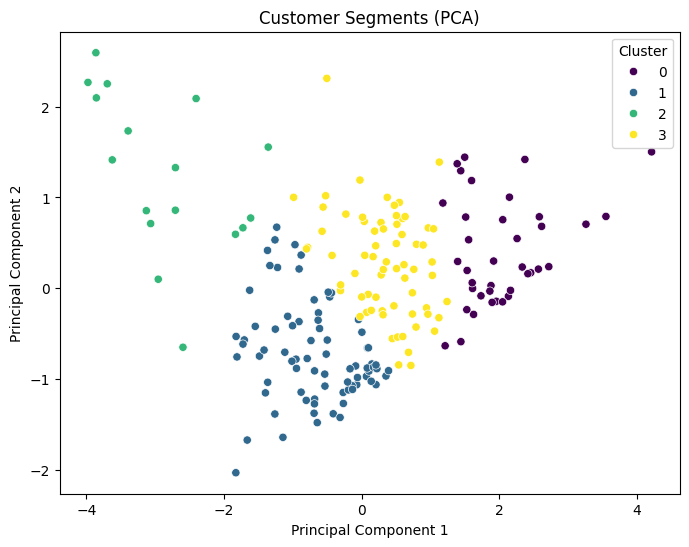

            Recency  Frequency     Monetary CustomerID  Region_Encoded
Cluster                                                               
0         34.736842   8.236842  5958.357895        NaN             NaN
1         50.675325   3.714286  2176.816883        NaN             NaN
2        243.823529   1.764706  1070.562353        NaN             NaN
3         79.656716   5.537313  4145.723881        NaN             NaN


In [21]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=principal_components[:, 0], y=principal_components[:, 1], hue=customer_data['Cluster'], palette='viridis')
plt.title('Customer Segments (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# 7. Analyze Cluster Characteristics
cluster_profile = customer_data.groupby('Cluster').mean()
print(cluster_profile)

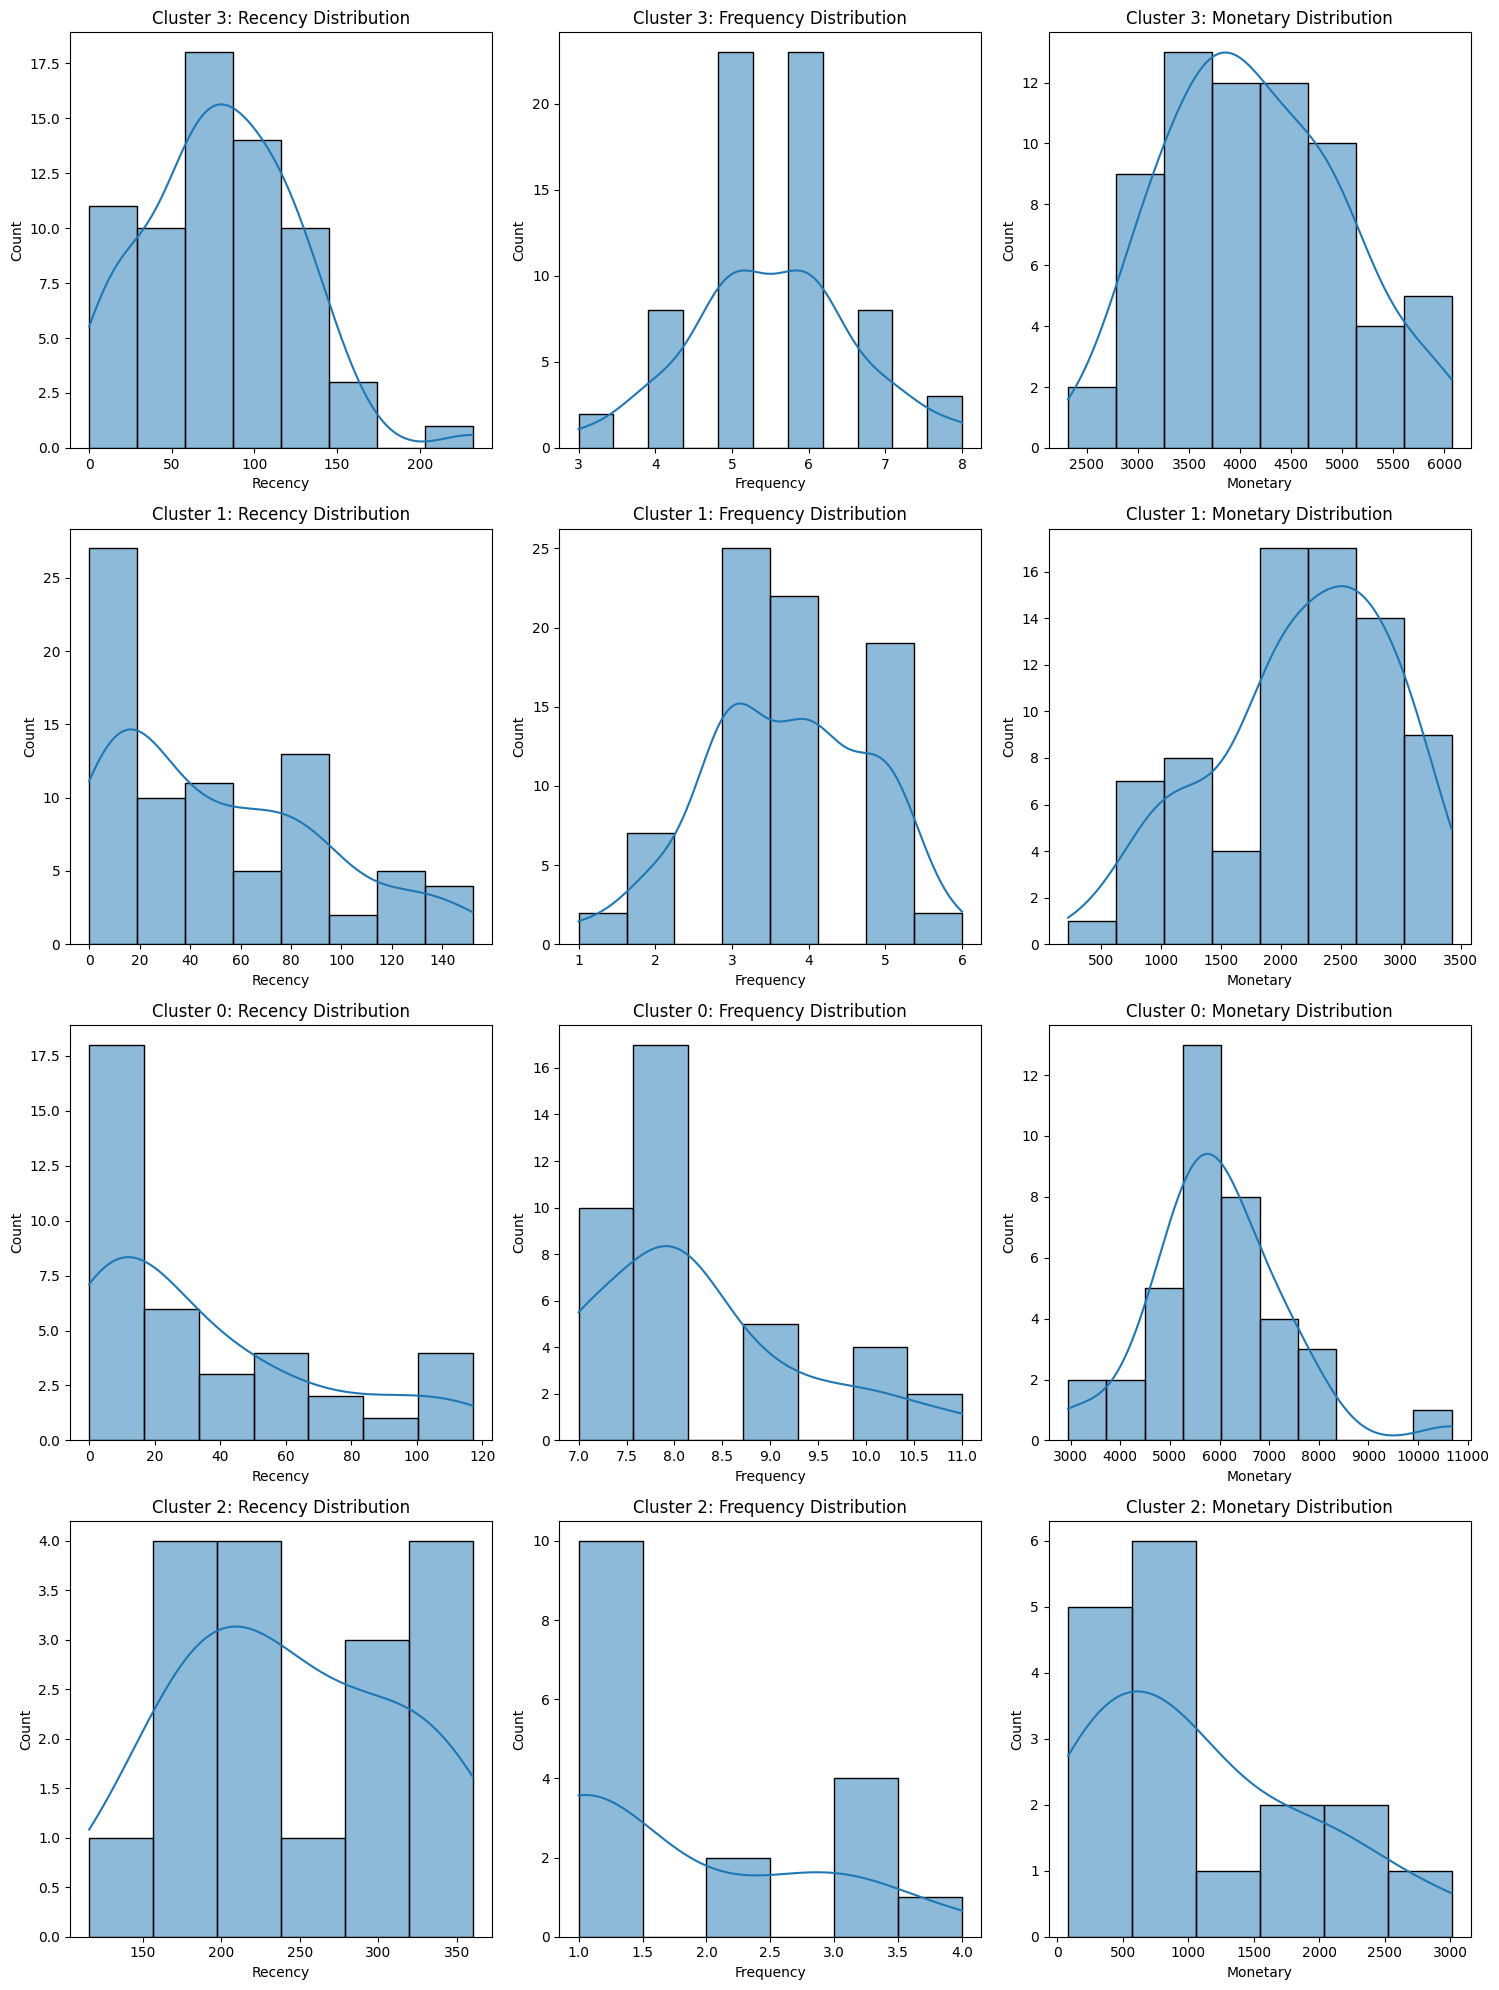

In [22]:
# 8. Visualize Cluster Distributions
num_clusters = len(customer_data['Cluster'].unique())

fig, axes = plt.subplots(num_clusters, 3, figsize=(15, 5 * num_clusters))

for i, cluster in enumerate(customer_data['Cluster'].unique()):
    cluster_data = customer_data[customer_data['Cluster'] == cluster]

    sns.histplot(cluster_data['Recency'], ax=axes[i, 0], kde=True)
    axes[i, 0].set_title(f"Cluster {cluster}: Recency Distribution")

    sns.histplot(cluster_data['Frequency'], ax=axes[i, 1], kde=True)
    axes[i, 1].set_title(f"Cluster {cluster}: Frequency Distribution")

    sns.histplot(cluster_data['Monetary'], ax=axes[i, 2], kde=True)
    axes[i, 2].set_title(f"Cluster {cluster}: Monetary Distribution")

plt.tight_layout()
plt.show()